In [2]:
import numpy as np
import igraph as ig
import leidenalg
import pandas as pd
import matplotlib.pyplot as plt
from qmap.toolkit import aligner
import torch
from pyutils import progress
import os
import powerlaw

from split_utils import read_fasta, Identity, compute_identity_stats
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#1C7ED6', '#77DD77', '#FFB347', '#FF6961', '#17BECF', '#F4D35E', "#ADFF2F", "#FF8200"])

/Users/anthonylavertu/mac_docs/pycharmProjects/QMAP/split_experiment/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
MIN_SEQ_LEN = 1
MAX_SEQ_LEN = 100

In [4]:
dm = np.load(f".cache/identity_matrix.npy")
with open(f".cache/row_ids.txt", 'r') as f:
    dm_ids = np.array([int(id_) for id_ in f.readlines()])

dataset = read_fasta("../data/build/dataset.fasta")
dataset = {int(id_): seq for id_, seq in dataset}

# Filter like for the other experiments
mask = np.array([MIN_SEQ_LEN <= len(dataset[id_]) <= MAX_SEQ_LEN for id_ in dm_ids])
dm = dm[mask][:, mask]  # Filter the distance matrix
dm_ids = dm_ids[mask]  # Filter the IDs accordingly

In [6]:
A = (dm > 0.6).astype(int)

In [18]:
edge_list = []
for i in progress(range(A.shape[0])):
    for j in range(i + 1, A.shape[1]):  # only upper triangle for undirected
        if A[i, j] == 1:
            edge_list.append((i, j))
nodeidx2id = {i: dm_ids[i] for i in range(len(dm_ids))}
if not os.path.exists(".cache"):
    os.makedirs(".cache")

# Create edgelist file
with open(".cache/graph.edgelist", 'w') as f:
    for i, j in edge_list:
        f.write(f"{i}\t{j}\n")

# Load graph
g = ig.Graph.Read_Edgelist(".cache/graph.edgelist", directed=False)

 100%|██████████████████████████████████|  19022/19022 [00:13<00:00, 314.08it/s] 


(array([1.4888e+04, 2.0510e+03, 1.1210e+03, 5.6600e+02, 2.0700e+02,
        7.9000e+01, 7.1000e+01, 2.4000e+01, 4.0000e+00, 1.1000e+01]),
 array([  0. ,  82.4, 164.8, 247.2, 329.6, 412. , 494.4, 576.8, 659.2,
        741.6, 824. ]),
 <BarContainer object of 10 artists>)

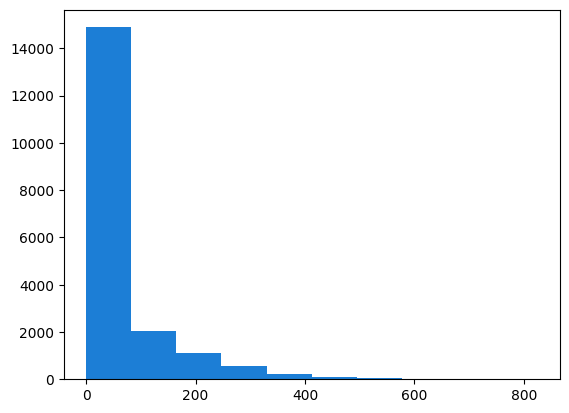

In [21]:
g: ig.Graph
plt.hist(g.degree())

In [35]:
fit = powerlaw.Fit(g.degree())
print("alpha =", fit.alpha)
print("xmin =", fit.xmin)

R, p = fit.distribution_compare('lognormal', 'power_law')
print("Loglikelihood ratio (R):", R)
print("p-value:", p)

Calculating best minimal value for power law fit
alpha = 4.527634916674943
xmin = 323.0
Loglikelihood ratio (R): 11.345692733490136
p-value: 0.0024746377459558327


Values less than or equal to 0 in data. Throwing out 0 or negative values


In [44]:
n_nodes = A.shape[0]
components = list(g.connected_components())
components = sorted(components, key=len, reverse=True)
for comp in components[:10]:
    print(f'Component of size {len(comp)}, representing {(len(comp) / n_nodes):.2%} of the graph')

Component of size 14454, representing 75.99% of the graph
Component of size 117, representing 0.62% of the graph
Component of size 106, representing 0.56% of the graph
Component of size 67, representing 0.35% of the graph
Component of size 60, representing 0.32% of the graph
Component of size 59, representing 0.31% of the graph
Component of size 53, representing 0.28% of the graph
Component of size 46, representing 0.24% of the graph
Component of size 45, representing 0.24% of the graph
Component of size 45, representing 0.24% of the graph


In [8]:
edge_list = []
for i in range(A.shape[0]):
    for j in range(i + 1, A.shape[1]):  # only upper triangle for undirected
        if A[i, j] == 1:
            edge_list.append((i, j))
nodeidx2id = {i: dm_ids[i] for i in range(len(dm_ids))}
if not os.path.exists(".cache/deepheuristic"):
    os.makedirs(".cache/deepheuristic")

# Create edgelist file
with open(".cache/deepheuristic/graph.edgelist", 'w') as f:
    for i, j in edge_list:
        f.write(f"{i}\t{j}\n")

# Load graph
g = ig.Graph.Read_Edgelist(".cache/deepheuristic/graph.edgelist", directed=False)

In [9]:
partition = leidenalg.find_partition(g, leidenalg.ModularityVertexPartition, n_iterations=-1)

# Now, make dataframe with communities
df = {"node_id": [], "community": []}
for i, comm in enumerate(partition):
    for node in comm:
        df["node_id"].append(nodeidx2id[node])
        df["community"].append(i)


df = pd.DataFrame(df)

In [12]:
df.groupby("community").size()

community
0       1083
1       1082
2        653
3        585
4        486
        ... 
2737       1
2738       1
2739       1
2740       1
2741       1
Length: 2742, dtype: int64